In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Short documentation of this notebook:

I will train GAN model in a bit different way. I will read already trained autoencoder in the same dataset, using it I will train discriminator. After that I will use autoencoder as a generator and I will put it to the GAN.

## Importing libraries

In [ ]:
import torch
# Import all dependencies
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Opening dataset of anime faces

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/anime images.zip', 'r') as zip_ref:
    zip_ref.extractall('image')

In [ ]:
image_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
batch_size = 128
path = '/content/image'
train_image_folder = ImageFolder(path, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

# Load the data

train_data_loader = DataLoader(train_image_folder, batch_size=batch_size, shuffle=True, num_workers=3,
                               pin_memory=True)
for inputs, labels in train_data_loader:
    inputs, labels = inputs.to(device), labels.to(device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/497 [00:00<?, ?it/s]

cpu


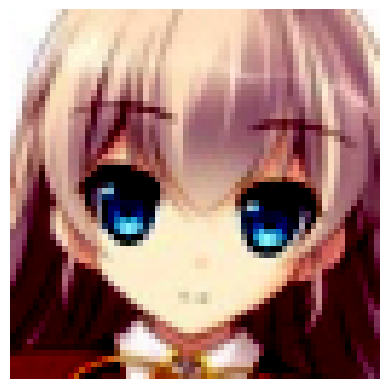

In [ ]:
import numpy as np
for real_images, _ in tqdm(train_data_loader):
  numpy_array = np.transpose(real_images[0], (1, 2, 0))
  print(real_images[0].device)
  # Visualize the image
  plt.imshow(numpy_array)
  plt.axis('off')
  plt.show()
  break

## Putting weights of a pre-trained autoencoder from the file

In [ ]:
path = '/content/drive/MyDrive/autoencoder_for_nic.pth'

# Open the file in read mode
with open(path, 'rb') as file:
    # Perform operations with the file here
    # For example, you can load the contents of the file into a variable
    file_contents = file.read()


In [ ]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),  # 8, 32, 32
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),  # 16, 16, 16
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),  # 32, 8, 8
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, padding=1),  # 64, 4, 4
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 3, padding=1),  # 128, 2, 2
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(1024, 2048, 2),  # 256, 1, 1
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
model = Autoencoder().to('cuda')
model.load_state_dict(torch.load(path))
generator = model.decoder

## Training discriminator (before putting it to the GAN)

In [ ]:
from scipy.stats import norm
path2 = '/content/drive/MyDrive/distribution.txt'

with open(path2) as f:
    mean = list(map(float, f.readline().split()))
    std = list(map(float, f.readline().split()))


def generate_input(n=1):
    return np.array([norm.rvs(mean[i], std[i] * 3, n) for i in range(len(mean))]).T.reshape((n,len(mean),1,1))

def generate_images(n=1):
    input = generate_input(n)
    x = torch.tensor(input)
    x = x.to(device)
    y = torch.tensor(x).clone().detach().to(torch.float)
    output = generator(y)
    output = output.cpu()
    r = output.detach().numpy()
    return r

In [ ]:
# Define a Discriminator model
discriminator = nn.Sequential(
    # In: 3 x 64 x 64

    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=64),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # Out: 64 x 32 x 32

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=128),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # Out: 128 x 16 x 16

    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=256),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # Out: 256 x 8 x 8

    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=512),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # Out: 512 x 4 x 4

    nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
    # Out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)
discriminator = discriminator.to(device)

In [ ]:
# Helper function for discriminator training process
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    # Generate fake images
    #latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    #fake_images = generator(latent)
    fake_images = generate_images(128)
    fake_images = torch.tensor(fake_images, device=device)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
import time
# Helper function for main training loop
def fit_discriminator(epochs, lr, start_idx=1):

    # Release occupied cache memory
    torch.cuda.empty_cache()

    # Lists for losses and scores
    real_scores = []
    fake_scores = []
    losses_discriminator  = []
    # Define optimizers for both models
    discriminator.to(device)

    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):

        t1 = time.time()
        for real_images, _ in tqdm(train_data_loader):

            # Train discriminator
            real_images = real_images.to(device)
            loss_discriminator, real_score, fake_score = train_discriminator(real_images, optimizer_discriminator)

        # Record losses and scores
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        losses_discriminator.append(loss_discriminator)
        # Print the losses and scores
        print(f"Epoch: {epoch}, loss_discriminator: {loss_discriminator}, real_score: {real_score}, fake_score: {fake_score}, time: {time.time() - t1}")


    return real_scores, fake_scores, losses_discriminator

In [ ]:
# Set up hyperparameters for our GAN
lr = 0.0002
epochs = 2

In [ ]:
# Start and record training process
history = fit_discriminator(epochs=2, lr=lr)

  0%|          | 0/497 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-9-82cfd4b46d2b>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(x).clone().detach().to(torch.float)
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Trigger

Epoch: 0, loss_discriminator: 9.321396646555513e-06, real_score: 0.9999959468841553, fake_score: 5.281949142954545e-06, time: 197.82453417778015


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 1, loss_discriminator: 3.951704002247425e-06, real_score: 0.9999968409538269, fake_score: 7.392138741124654e-07, time: 187.94486379623413


## Training GAN (generator in this model is autoencoder)

In [ ]:
# Helper function for generator training process
def train_generator(opt_g):

    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    #latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    #fake_images = generator(latent)

    fake_images = generate_images(batch_size)
    fake_images = torch.tensor(fake_images, device=device)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item(), fake_images

In [ ]:
def plot_fakes(fakes):
  num_images_to_plot = 10

  # Create a figure with subplots
  fig, axes = plt.subplots(1, num_images_to_plot, figsize=(20, 4))

  # Plot each image
  for i in range(num_images_to_plot):
      # Transpose and rotate the image
      img = np.transpose(fakes[i], (1, 2, 0))
      img = np.rot90(img, k=-1)

      # Plot the image on the corresponding subplot
      axes[i].imshow(img)
      axes[i].axis('off')

  # Show the plot
  plt.show()

In [ ]:
import time
# Helper function for main training loop
def fit(epochs, lr, start_idx=1):

    # Release occupied cache memory
    torch.cuda.empty_cache()

    # Lists for losses and scores
    real_scores = []
    fake_scores = []
    epoch_losses_discriminator  = []
    epoch_losses_generator = []
    # Define optimizers for both models
    discriminator.to(device)

    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    fakes = []
    for epoch in range(epochs):
        losses_generator = []
        losses_discriminator = []
        t1 = time.time()
        i = 0
        for real_images, _ in tqdm(train_data_loader):

            i+=1
            # Train discriminator
            real_images = real_images.to(device)
            loss_discriminator, real_score, fake_score = train_discriminator(real_images, optimizer_discriminator)
            loss_generator, fakes = train_generator(optimizer_generator)
            losses_generator.append(loss_generator)
            losses_discriminator.append(loss_discriminator)

        lss_gen = sum(losses_generator) / len(losses_generator)
        lss_dis = sum(losses_discriminator) / len(losses_discriminator)
        epoch_losses_generator.append(lss_gen)
        epoch_losses_discriminator.append(lss_dis)
        fakes = fakes.cpu()
        plot_fakes(fakes)
        # Record losses and scores
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Print the losses and scores
        print(f"Epoch: {epoch}, loss_discriminator: {lss_dis}, loss_generator: {lss_gen}, time: {time.time() - t1}")


    return real_scores, fake_scores, losses_discriminator, loss_generator

  0%|          | 0/497 [00:00<?, ?it/s]

<ipython-input-9-82cfd4b46d2b>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(x).clone().detach().to(torch.float)


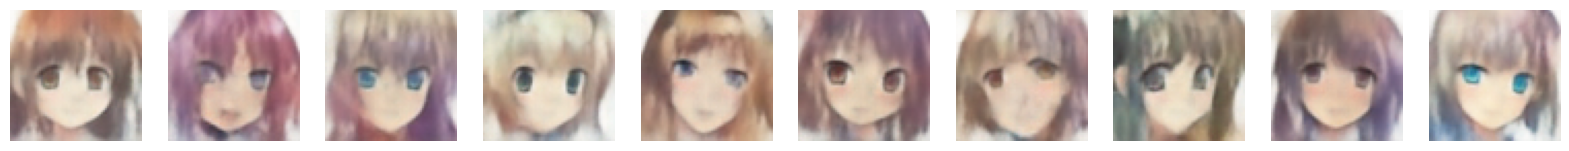

Epoch: 0, loss_discriminator: 5.962882121654651e-08, loss_generator: 23.6103629912409, time: 306.2836799621582


  0%|          | 0/497 [00:00<?, ?it/s]

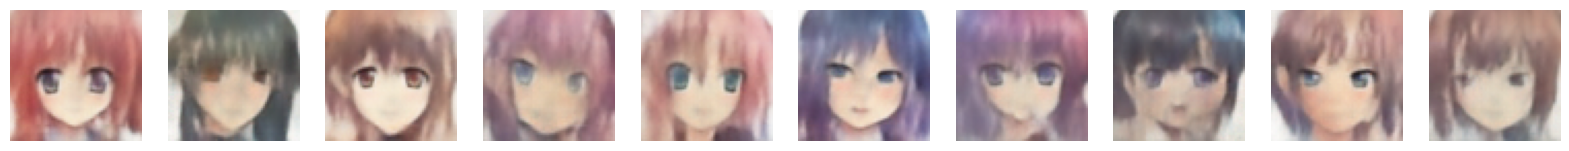

Epoch: 1, loss_discriminator: 5.701733269378514e-10, loss_generator: 25.143087264277806, time: 306.1941933631897


  0%|          | 0/497 [00:00<?, ?it/s]

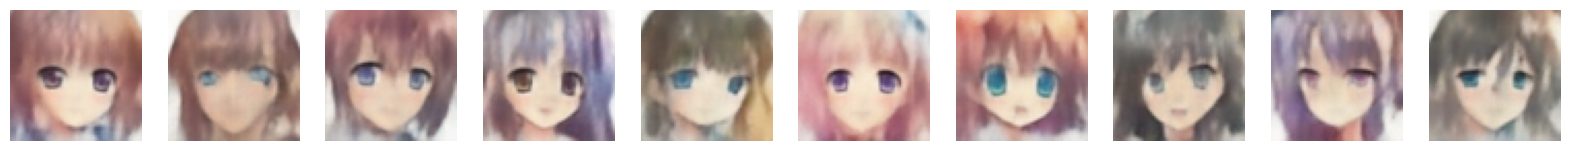

Epoch: 2, loss_discriminator: 2.70280908412601e-10, loss_generator: 25.736679737236898, time: 307.0918471813202


  0%|          | 0/497 [00:00<?, ?it/s]

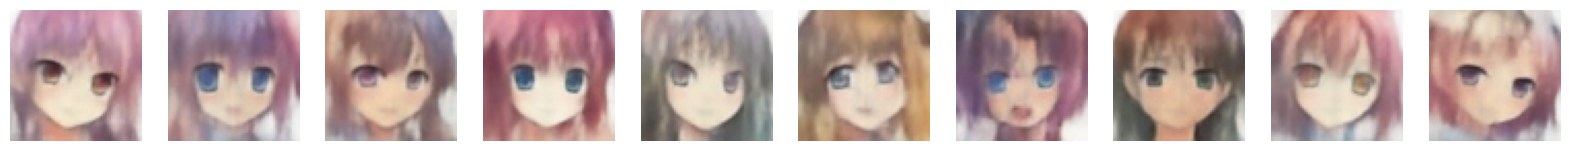

Epoch: 3, loss_discriminator: 1.3420486583239622e-10, loss_generator: 26.206731155364807, time: 312.71477699279785


  0%|          | 0/497 [00:00<?, ?it/s]

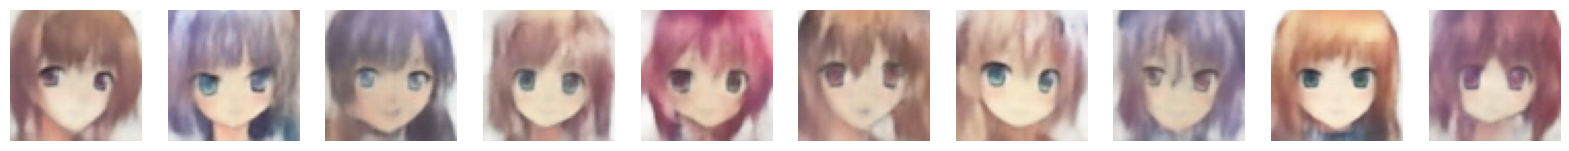

Epoch: 4, loss_discriminator: 9.556808267322668e-11, loss_generator: 26.568564094528107, time: 316.4885621070862


  0%|          | 0/497 [00:00<?, ?it/s]

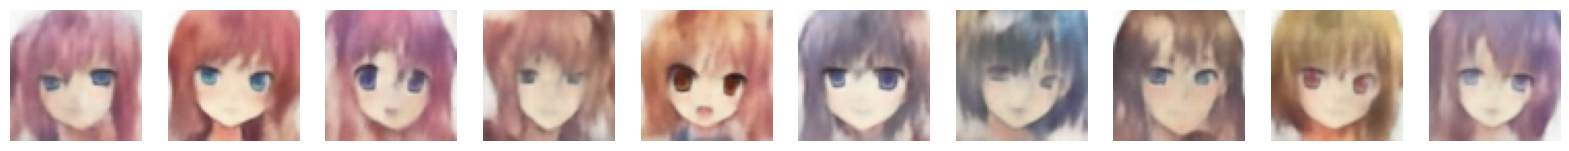

Epoch: 5, loss_discriminator: 6.002133325256161e-11, loss_generator: 26.833683129047724, time: 318.4696981906891


  0%|          | 0/497 [00:00<?, ?it/s]

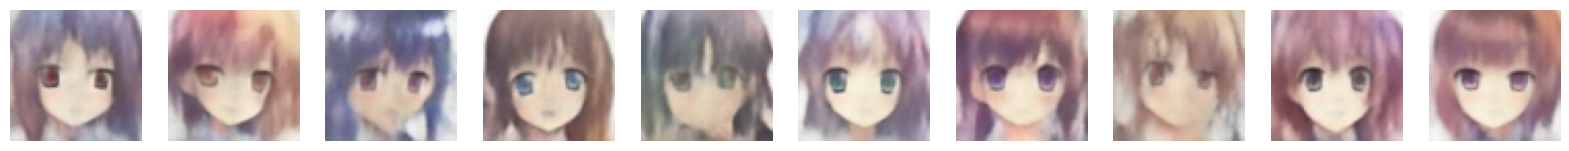

Epoch: 6, loss_discriminator: 4.7734594693139563e-11, loss_generator: 27.093745452297526, time: 319.79489064216614


  0%|          | 0/497 [00:00<?, ?it/s]

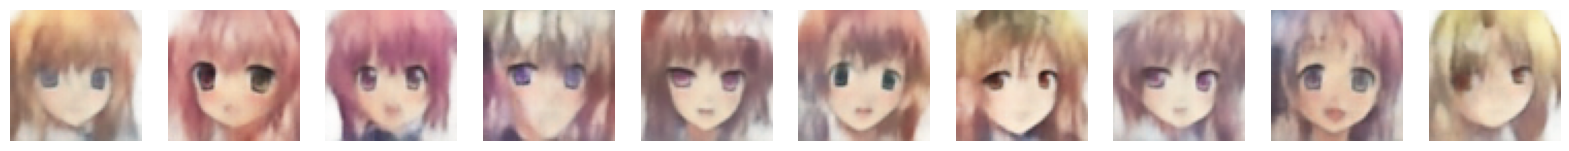

Epoch: 7, loss_discriminator: 3.373634723296637e-11, loss_generator: 27.30233476051622, time: 320.509006023407


  0%|          | 0/497 [00:00<?, ?it/s]

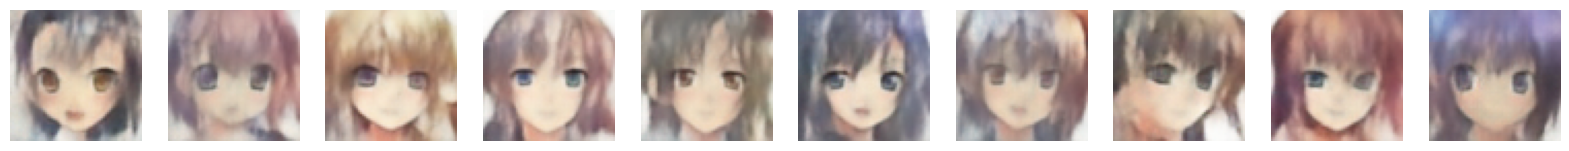

Epoch: 8, loss_discriminator: 2.4836695614964548e-11, loss_generator: 27.51326161850866, time: 321.0673637390137


  0%|          | 0/497 [00:00<?, ?it/s]

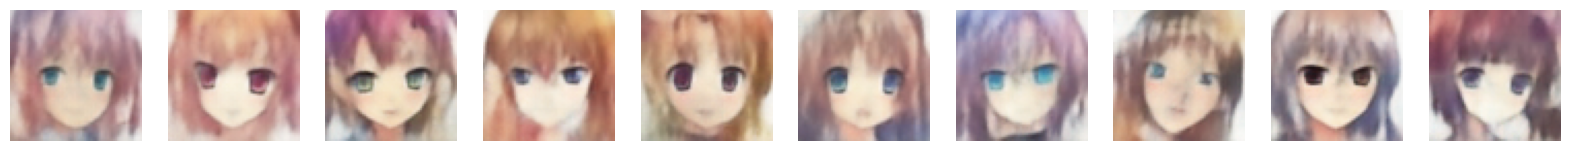

Epoch: 9, loss_discriminator: 1.7146210240463009e-10, loss_generator: 28.177699739544444, time: 322.2795593738556


  0%|          | 0/497 [00:00<?, ?it/s]

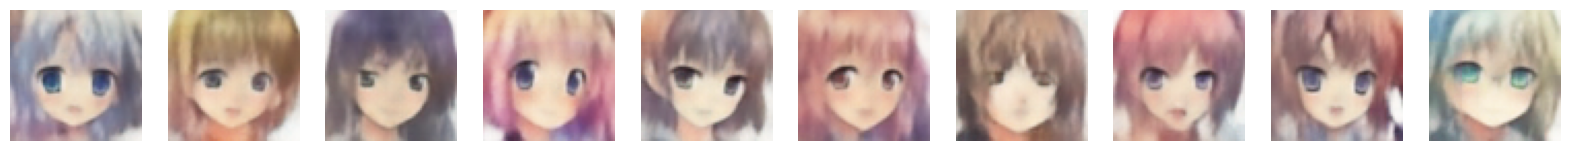

Epoch: 10, loss_discriminator: 2.4816510768539116e-11, loss_generator: 29.07541886373785, time: 323.87317633628845


  0%|          | 0/497 [00:00<?, ?it/s]

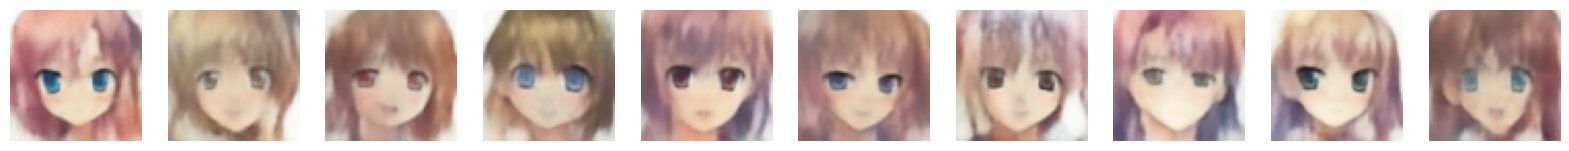

Epoch: 11, loss_discriminator: 3.8611704862442446e-12, loss_generator: 29.107382089319362, time: 330.4705243110657


  0%|          | 0/497 [00:00<?, ?it/s]

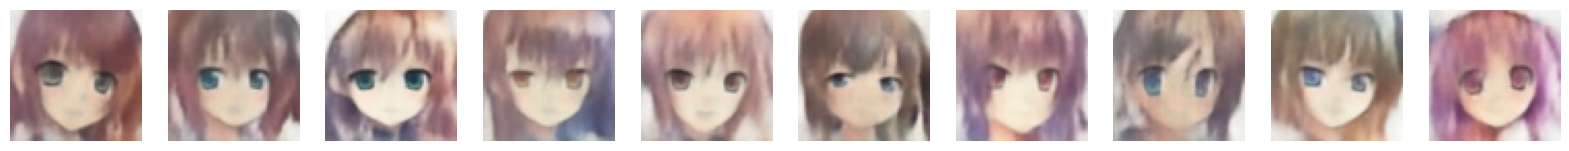

Epoch: 12, loss_discriminator: 1.2248185993557116e-11, loss_generator: 29.14325161862901, time: 336.4611186981201


  0%|          | 0/497 [00:00<?, ?it/s]

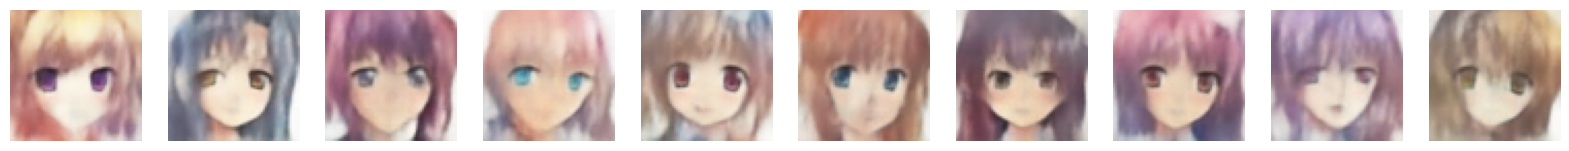

Epoch: 13, loss_discriminator: 5.738429284234174e-12, loss_generator: 29.199756683718032, time: 332.4597020149231


  0%|          | 0/497 [00:00<?, ?it/s]

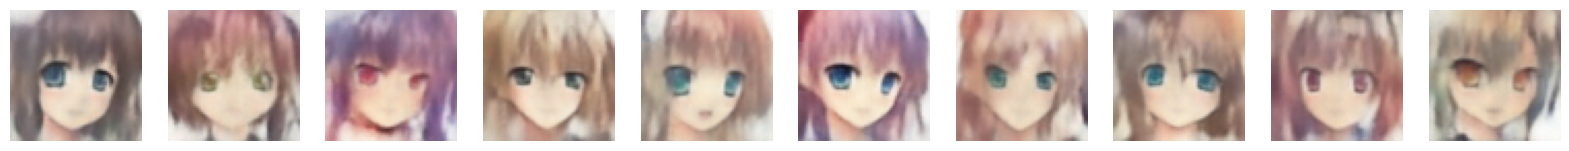

Epoch: 14, loss_discriminator: 5.640891551539131e-12, loss_generator: 29.243882538087412, time: 328.16014337539673


  0%|          | 0/497 [00:00<?, ?it/s]

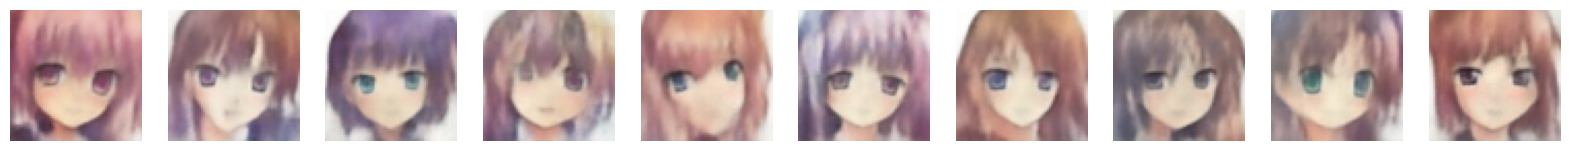

Epoch: 15, loss_discriminator: 3.5472574808873656e-12, loss_generator: 29.3107859920448, time: 330.57764434814453


  0%|          | 0/497 [00:00<?, ?it/s]

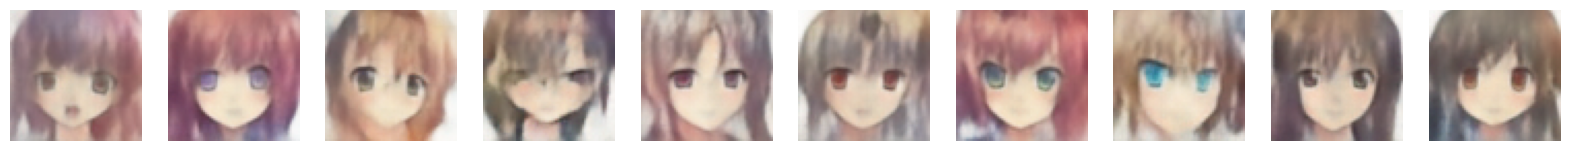

Epoch: 16, loss_discriminator: 1.8849522942062437e-12, loss_generator: 29.360546319297622, time: 333.0575518608093


  0%|          | 0/497 [00:00<?, ?it/s]

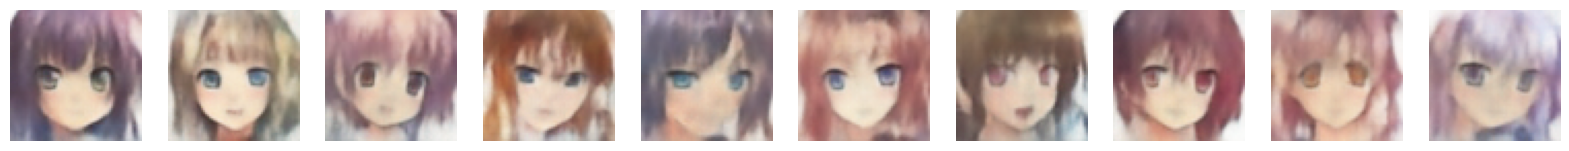

Epoch: 17, loss_discriminator: 1.463002891822535e-12, loss_generator: 29.416398756460886, time: 334.5376274585724


  0%|          | 0/497 [00:00<?, ?it/s]

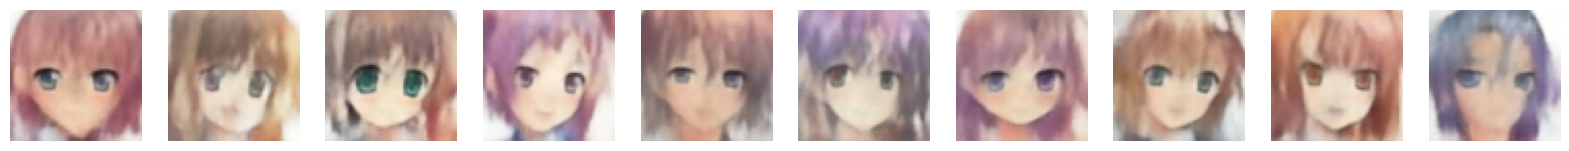

Epoch: 18, loss_discriminator: 1.566358900799411e-12, loss_generator: 29.464649588049536, time: 333.88629055023193


  0%|          | 0/497 [00:00<?, ?it/s]

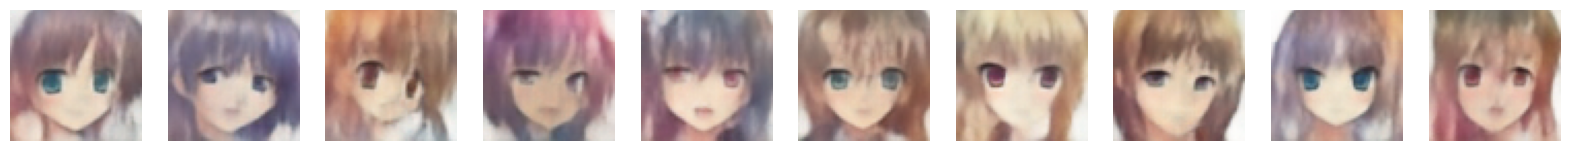

Epoch: 19, loss_discriminator: 3.837265626382258e-12, loss_generator: 29.514714116301814, time: 334.35349321365356


  0%|          | 0/497 [00:00<?, ?it/s]

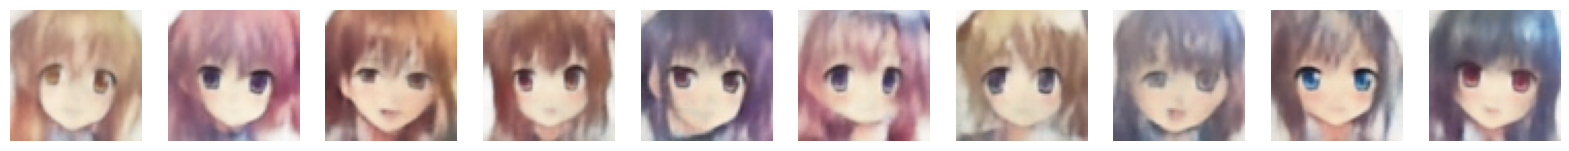

Epoch: 20, loss_discriminator: 1.2092274226619575e-12, loss_generator: 29.567304112301986, time: 334.9391920566559


  0%|          | 0/497 [00:00<?, ?it/s]

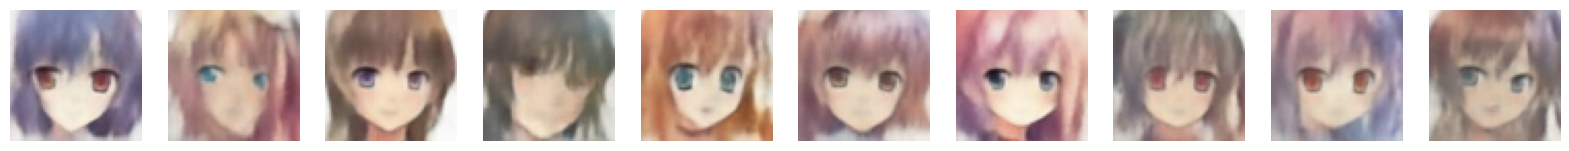

Epoch: 21, loss_discriminator: 1.2240170619639797e-12, loss_generator: 29.609649646689956, time: 337.262531042099


  0%|          | 0/497 [00:00<?, ?it/s]

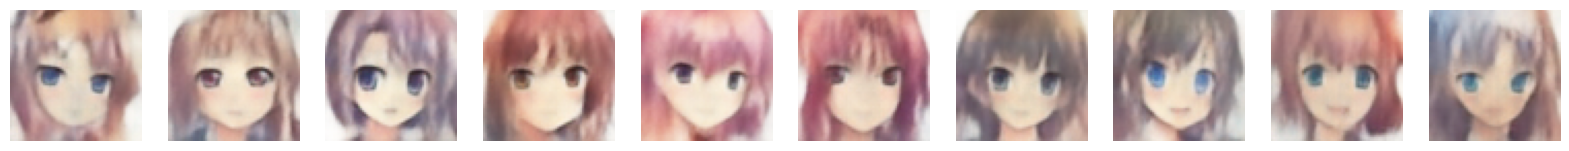

Epoch: 22, loss_discriminator: 3.0786060271120377e-12, loss_generator: 29.6407731783462, time: 337.7245180606842


  0%|          | 0/497 [00:00<?, ?it/s]

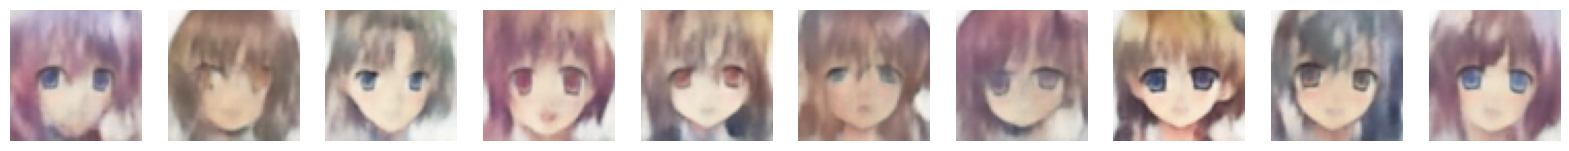

Epoch: 23, loss_discriminator: 1.1275672889000289e-12, loss_generator: 29.67436465411119, time: 338.6881489753723


  0%|          | 0/497 [00:00<?, ?it/s]

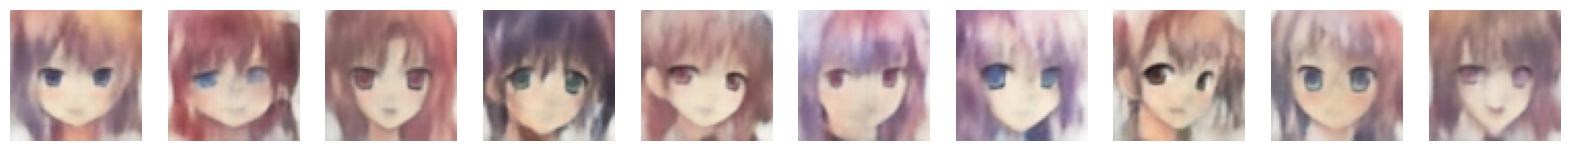

Epoch: 24, loss_discriminator: 9.55342346606311e-13, loss_generator: 29.723390920781036, time: 339.5479438304901


  0%|          | 0/497 [00:00<?, ?it/s]

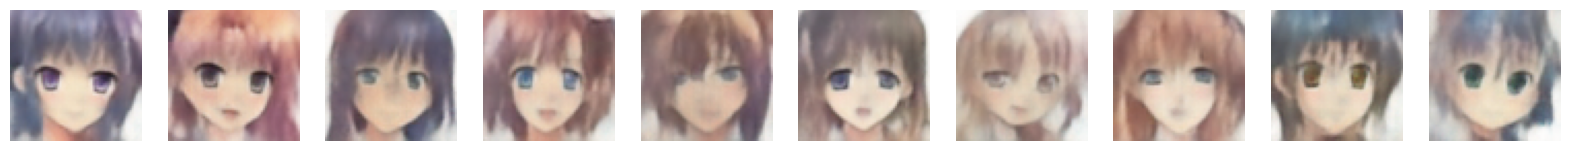

Epoch: 25, loss_discriminator: 1.0533260822262047e-12, loss_generator: 29.746218813736913, time: 338.8941738605499


  0%|          | 0/497 [00:00<?, ?it/s]

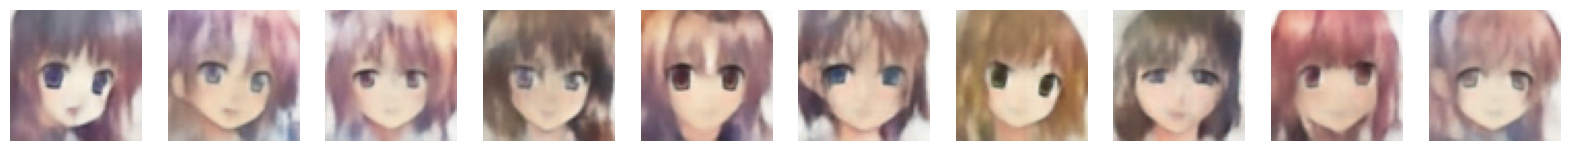

Epoch: 26, loss_discriminator: 3.560285928164308e-12, loss_generator: 29.79323846521512, time: 340.263019323349


  0%|          | 0/497 [00:00<?, ?it/s]

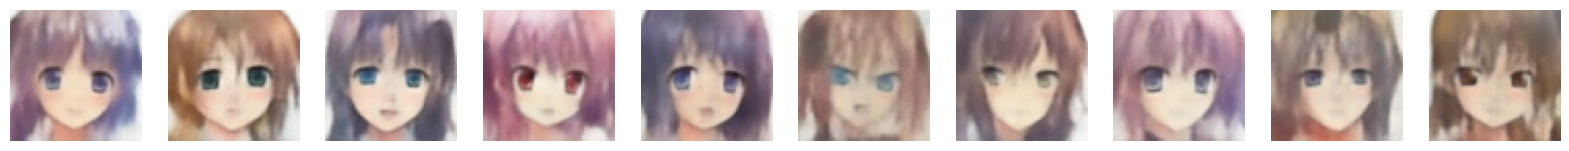

Epoch: 27, loss_discriminator: 3.1678659423194002e-12, loss_generator: 29.842100469639124, time: 339.57045245170593


  0%|          | 0/497 [00:00<?, ?it/s]

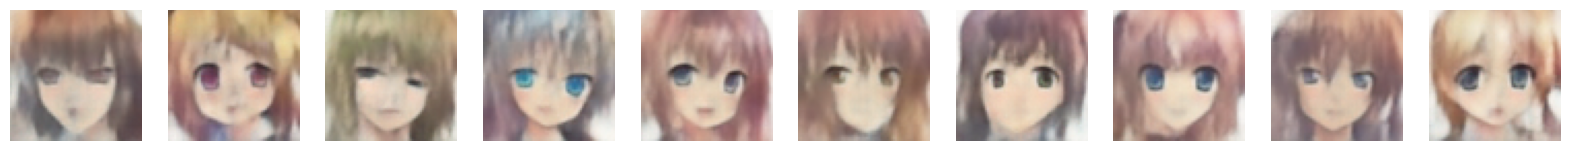

Epoch: 28, loss_discriminator: 8.75212834988702e-13, loss_generator: 29.87666594046702, time: 336.2482647895813


  0%|          | 0/497 [00:00<?, ?it/s]

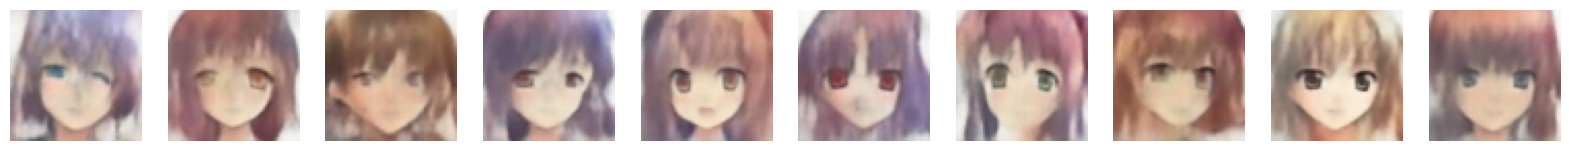

Epoch: 29, loss_discriminator: 1.0181130625858456e-12, loss_generator: 29.904701113940725, time: 337.05704498291016


In [ ]:
history = fit(epochs=30, lr=lr)


As we see our generated images are not bad